In [5]:
from datasetsforecast.m4 import M4
from pathlib import Path
import pandas as pd


In [12]:
def _transform_group(df):
    unique_id = df.unique_id.iloc[0]
    _start = pd.Timestamp("2020-01-01")
    _end = _start + pd.DateOffset(days=int(df.count()[0]) - 1)
    date_idx = pd.date_range(start=_start, end=_end, freq="D", name="ds")
    res_df = pd.DataFrame(data=[], index=date_idx).reset_index()
    res_df["unique_id"] = unique_id
    res_df["y"] = df.y.values
    return res_df

def m4_df():
    y_df, _, _ = M4.load(directory=str(Path.home()), group="Daily")
    y_df = (
        y_df.groupby("unique_id")
        .apply(_transform_group)
        .reset_index(drop=True)
    )
    return y_df

m4 = m4_df()

In [23]:
m4_d1 = m4[m4.unique_id == 'D1']

In [16]:
from pyspark.sql import SparkSession
from pyspark.sql.functions import to_date

# Create a SparkSession
spark = SparkSession.builder.appName("M4Daily").getOrCreate()

In [24]:
# Convert pandas DataFrame to Spark DataFrame
spark_df = spark.createDataFrame(m4_d1)

# Convert 'ds' column to date type
spark_df = spark_df.withColumn("ds", to_date("ds"))

# Show the first few rows and print the schema to verify the conversion
spark_df.show(5)
spark_df.printSchema()

# Get the number of unique IDs in the Spark DataFrame
num_unique_ids = spark_df.select("unique_id").distinct().count()
print(f"Number of unique IDs in Spark DataFrame: {num_unique_ids}")


+----------+---------+------+
|        ds|unique_id|     y|
+----------+---------+------+
|2020-01-01|       D1|1017.1|
|2020-01-02|       D1|1019.3|
|2020-01-03|       D1|1017.0|
|2020-01-04|       D1|1019.2|
|2020-01-05|       D1|1018.7|
+----------+---------+------+
only showing top 5 rows

root
 |-- ds: date (nullable = true)
 |-- unique_id: string (nullable = true)
 |-- y: double (nullable = true)

Number of unique IDs in Spark DataFrame: 1


In [28]:
from pyspark.sql import functions as F
from pyspark.sql.window import Window

w = Window.partitionBy('unique_id').orderBy('ds')

# Create lag features (daily dataset - 1 week and 2 weeks)
df_with_lags = (spark_df
    .withColumn('lag_1w', F.lag('y', 7).over(w))
    .withColumn('lag_2w', F.lag('y', 14).over(w))
    .fillna(0)
)

df_with_lags.show()

+----------+---------+------+------+------+
|        ds|unique_id|     y|lag_1w|lag_2w|
+----------+---------+------+------+------+
|2020-01-01|       D1|1017.1|   0.0|   0.0|
|2020-01-02|       D1|1019.3|   0.0|   0.0|
|2020-01-03|       D1|1017.0|   0.0|   0.0|
|2020-01-04|       D1|1019.2|   0.0|   0.0|
|2020-01-05|       D1|1018.7|   0.0|   0.0|
|2020-01-06|       D1|1015.6|   0.0|   0.0|
|2020-01-07|       D1|1018.5|   0.0|   0.0|
|2020-01-08|       D1|1018.3|1017.1|   0.0|
|2020-01-09|       D1|1018.4|1019.3|   0.0|
|2020-01-10|       D1|1021.5|1017.0|   0.0|
|2020-01-11|       D1|1023.0|1019.2|   0.0|
|2020-01-12|       D1|1023.3|1018.7|   0.0|
|2020-01-13|       D1|1020.5|1015.6|   0.0|
|2020-01-14|       D1|1021.4|1018.5|   0.0|
|2020-01-15|       D1|1018.1|1018.3|1017.1|
|2020-01-16|       D1|1022.6|1018.4|1019.3|
|2020-01-17|       D1|1022.6|1021.5|1017.0|
|2020-01-18|       D1|1021.0|1023.0|1019.2|
|2020-01-19|       D1|1020.1|1023.3|1018.7|
|2020-01-20|       D1|1017.0|102

In [47]:
from pyspark.sql import functions as F
from pyspark.sql.window import Window

def ewma(df, value_column, date_column, alpha=0.3, id_column=None):
    window = Window.partitionBy(id_column).orderBy(date_column).rowsBetween(Window.unboundedPreceding, 0) if id_column else Window.orderBy(date_column).rowsBetween(Window.unboundedPreceding, 0)
    
    return df.withColumn('row_number', F.row_number().over(window)) \
             .withColumn('weight', F.pow(1 - alpha, F.col('row_number') - 1)) \
             .withColumn('weighted_value', F.col(value_column) * F.col('weight')) \
             .withColumn('ewma', F.sum('weighted_value').over(window) / F.sum('weight').over(window)) \
             .drop('row_number', 'weight', 'weighted_value')

# Usage example
df_with_ewma = ewma(spark_df, value_column='y', date_column='ds', id_column='unique_id', alpha=0.3)
df_with_ewma.show()

+----------+---------+------+------------------+
|        ds|unique_id|     y|              ewma|
+----------+---------+------+------------------+
|2020-01-01|       D1|1017.1|            1017.1|
|2020-01-02|       D1|1019.3|1018.0058823529412|
|2020-01-03|       D1|1017.0|1017.7808219178081|
|2020-01-04|       D1|1019.2|1017.9729964469008|
|2020-01-05|       D1|1018.7|1018.0359417258661|
|2020-01-06|       D1|1015.6|1017.8967424528332|
|2020-01-07|       D1|1018.5|  1017.91994508338|
|2020-01-08|       D1|1018.3|1017.9299092444212|
|2020-01-09|       D1|1018.4|1017.9383810513627|
|2020-01-10|       D1|1021.5|1017.9827516627128|
|2020-01-11|       D1|1023.0|1018.0261267848027|
|2020-01-12|       D1|1023.3|1018.0578503920038|
|2020-01-13|       D1|1020.5| 1018.068090354218|
|2020-01-14|       D1|1021.4|1018.0778412498927|
|2020-01-15|       D1|1018.1|1018.0778865506878|
|2020-01-16|       D1|1022.6|1018.0843487299298|
|2020-01-17|       D1|1022.6|1018.0888612772459|
|2020-01-18|       D

In [49]:
import seaborn as sns
import matplotlib.pyplot as plt


24/09/17 01:54:36 WARN HeartbeatReceiver: Removing executor driver with no recent heartbeats: 958916 ms exceeds timeout 120000 ms
24/09/17 01:54:36 WARN SparkContext: Killing executors is not supported by current scheduler.
24/09/17 01:54:36 ERROR Inbox: Ignoring error
org.apache.spark.SparkException: Exception thrown in awaitResult: 
	at org.apache.spark.util.SparkThreadUtils$.awaitResult(SparkThreadUtils.scala:56)
	at org.apache.spark.util.ThreadUtils$.awaitResult(ThreadUtils.scala:310)
	at org.apache.spark.rpc.RpcTimeout.awaitResult(RpcTimeout.scala:75)
	at org.apache.spark.rpc.RpcEnv.setupEndpointRefByURI(RpcEnv.scala:102)
	at org.apache.spark.rpc.RpcEnv.setupEndpointRef(RpcEnv.scala:110)
	at org.apache.spark.util.RpcUtils$.makeDriverRef(RpcUtils.scala:36)
	at org.apache.spark.storage.BlockManagerMasterEndpoint.driverEndpoint$lzycompute(BlockManagerMasterEndpoint.scala:124)
	at org.apache.spark.storage.BlockManagerMasterEndpoint.org$apache$spark$storage$BlockManagerMasterEndpoint$$

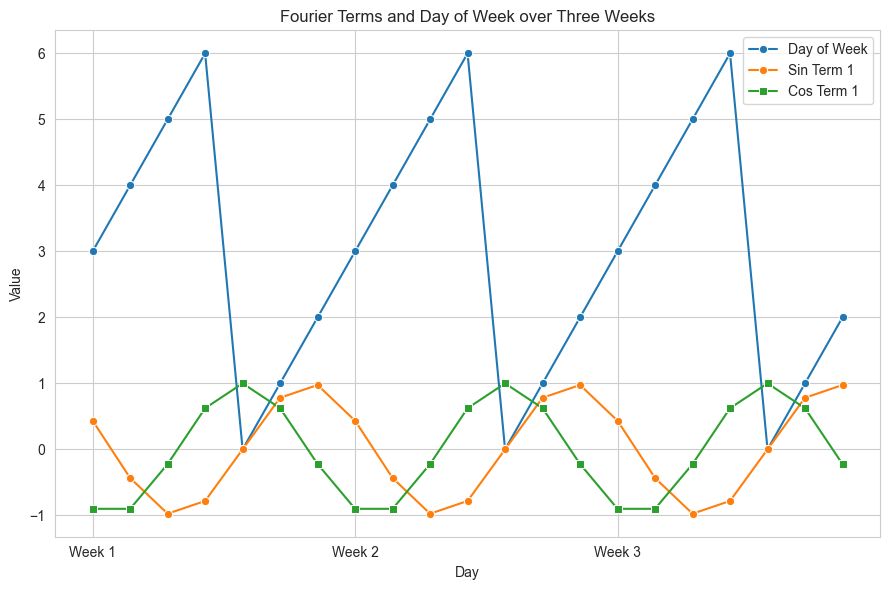

In [48]:
from pyspark.sql import functions as F
from pyspark.sql.types import DoubleType
import numpy as np

def fourier_features_with_dow(spark, df, date_col, num_terms=3, period=7):
    def trig_term(func):
        return F.udf(lambda x, n, p: float(func(2 * np.pi * n * x / p)), DoubleType())

    sin_term, cos_term = trig_term(np.sin), trig_term(np.cos)
    
    df = df.withColumn('day_of_week', F.dayofweek(F.col(date_col)) - 1)
    
    for n in range(1, num_terms + 1):
        df = df.withColumn(f'sin_term_{n}', sin_term(F.col('day_of_week'), F.lit(n), F.lit(period))) \
               .withColumn(f'cos_term_{n}', cos_term(F.col('day_of_week'), F.lit(n), F.lit(period)))
    
    return df

df_with_fourier = fourier_features_with_dow(spark, spark_df, date_col='ds', num_terms=3, period=7)
plot_data = df_with_fourier.select('day_of_week', "ds",'sin_term_1', 'cos_term_1').limit(21).collect()

# Prepare data for plotting
days = [row['day_of_week'] for row in plot_data]
sin_term = [row['sin_term_1'] for row in plot_data]
cos_term = [row['cos_term_1'] for row in plot_data]

# Create the plot
sns.set_style("whitegrid")
plt.figure(figsize=(9, 6))

# Create the plot
sns.lineplot(x=range(len(days)), y=days, marker='o', label='Day of Week')
sns.lineplot(x=range(len(days)), y=sin_term, marker='o', label='Sin Term 1')
sns.lineplot(x=range(len(days)), y=cos_term, marker='s', label='Cos Term 1')

# Customize the plot
plt.xlabel('Day')
plt.ylabel('Value')
plt.title('Fourier Terms and Day of Week over Three Weeks')
plt.xticks(range(0, len(days), 7), ['Week 1', 'Week 2', 'Week 3'])
plt.legend()

# Show the plot
plt.tight_layout()
plt.show()

In [9]:
from mmf_sa import run_forecast